In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyxcompact.simulation import Simulation
from pyxcompact.simulationfile import CheckpointFile
from itertools import product
%matplotlib widget

In /localhome/hi209/Codes/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /localhome/hi209/Codes/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /localhome/hi209/Codes/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /localhome/hi209/Codes/intelpython3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /loca

In [2]:
# new restart file
ret_new = 180

# old snapshot: params
ret_old = 180
old_snap = "jonathan_re180"
scale_to_wall_units = True

In [3]:
def count_zeros(arr):
    print(f"number of zeros: {arr.size - np.count_nonzero(arr)}")
    print(f"percentage of zeros: {(arr.size - np.count_nonzero(arr))/arr.size*100}%")

In [4]:
# get the simulation and mesh
sim  = Simulation('../input.i3d')
n_new = {coord : sim.getInputParam(f"BasicParam/n{coord}") for coord in ["x", "y", "z"]}

Unknown parameter encountered: 'fprint = 5'
Unknown parameter encountered: 'fprintcfl = 5'
Data type not understood: 'xp_plx2d = 1., 2., 3.'
Data type not understood: 'yp_ply2d = 0.2, 0.5'
Unknown parameter encountered: 'Sc(1) = 1.0'
Unknown parameter encountered: 'bcphiy1(1) = 1.'
Unknown parameter encountered: 'bcphiyn(1) = 0.'
Unknown namelist encountered: 'None'
Unknown namelist encountered: 'None'
Unknown parameter encountered: 'xyzprobes(:,1) = 1. , 0.2 , 0.1'
Unknown parameter encountered: 'xyzprobes(:,2) = 1. , 0.2 , 0.2'
Unknown parameter encountered: 'xyzprobes(:,3) = 1. , 0.2 , 0.3'
Unknown parameter encountered: 'xyzprobes(:,4) = 1. , 0.2 , 0.4'
Expected file ../monitor.txt not found


In [5]:
# read old field
o_sim  = Simulation('./jonathan_re180.i3d')
##old_fld, x_old, y_old, z_old = xc.read_brutalbin(old_snap, nfo_old_snap) # shape of field: (nztot, nytot, nxtot, 3)
x_old = o_sim.x; y_old = o_sim.y; z_old = o_sim.z
nx_old = len(x_old); ny_old = len(y_old); nz_old = len(z_old)
old_fld = np.fromfile(old_snap, dtype=np.float64, count=3*nx_old*ny_old*nz_old).reshape((3,nz_old,ny_old,nx_old))
y_old *= ret_old
print("Old field:")
count_zeros(old_fld)

Data type not understood: 'xp_plx2d = 1., 2., 3.'
Data type not understood: 'yp_ply2d = 0.2, 0.5'
Unknown parameter encountered: 'Sc(1) = 1.0'
Unknown namelist encountered: 'None'
Unknown namelist encountered: 'None'
Unknown parameter encountered: 'xyzprobes(:,1) = 1. , 0.2 , 0.1'
Unknown parameter encountered: 'xyzprobes(:,2) = 1. , 0.2 , 0.2'
Unknown parameter encountered: 'xyzprobes(:,3) = 1. , 0.2 , 0.3'
Unknown parameter encountered: 'xyzprobes(:,4) = 1. , 0.2 , 0.4'
Expected file monitor.txt not found
Old field:
number of zeros: 65536
percentage of zeros: 0.3454231433506045%


In [6]:
# mask y_old and old_fld
yold_mask = [a<=ret_new or (a-2*ret_old)>-ret_new for a in y_old] # get the mask
y_old = y_old[yold_mask] # mask y_old
# fix upper wall of y_old
for ii,v in enumerate(y_old):
    if v > ret_new:
        y_old[ii] = 2*ret_new - (2*ret_old - y_old[ii])

In [7]:
old_fld = old_fld[:,:,yold_mask,:]

In [8]:
if scale_to_wall_units:
    rec = (ret_old/0.116)**(1.0/0.88)
    utau = ret_old/rec
    old_fld /= utau

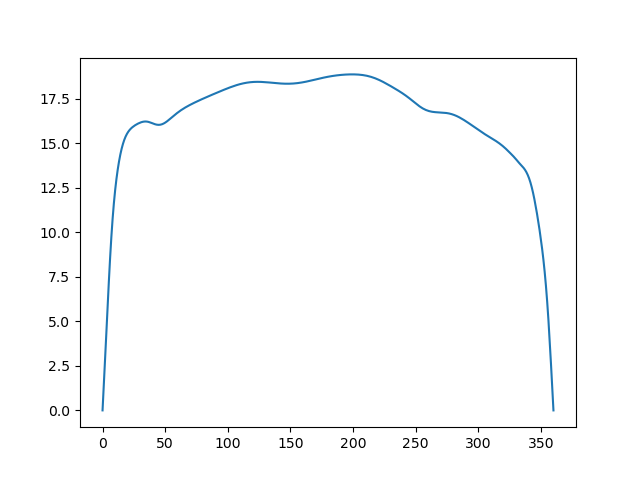

In [9]:
# check old field after cutting
fig, ax = plt.subplots()
ax.plot(y_old,old_fld[0,10,:,10])

In [10]:
# allocate new field
new_fld = np.zeros((3,n_new["z"],n_new["y"],n_new["x"]))
y_new = sim.y * ret_new

In [11]:
# get minimum dimensions
min_x = np.amin([n_new["x"],nx_old])
min_z = np.amin([n_new["z"],nz_old])

In [12]:
# interpolate first
for ic, ix, iz in product(range(3),range(min_x),range(min_z)):
    new_fld[ic,iz,:,ix] = np.interp(y_new,y_old,old_fld[ic,iz,:,ix])
print("After interpolation:")
count_zeros(new_fld)

After interpolation:
number of zeros: 22207680
percentage of zeros: 70.5166895290352%


In [13]:
# how many points in x are still zero?
nx_diff = n_new["x"] - min_x
# how many integer times can you pad a min_x sized chunk?
intx = nx_diff // min_x
# how many points do you then add?
remx = nx_diff % min_x

# do the padding in x
if nx_diff > 0:
    for ii in range(intx): # pad a min_x-sized chunk intx times
        new_fld[:,0:min_z,:,(ii+1)*min_x:(ii+2)*min_x] = new_fld[:,0:min_z,:,0:min_x]
    # pad remaining points
    new_fld[:,0:min_z,:,(intx+1)*min_x:] = new_fld[:,0:min_z,:,0:remx]
    
# the field should be now full, at least in the x-direction
# now, only the z direction needs to be filled

# how many points need to be filled in the z direction?
nz_diff = n_new["z"] - min_z
# how many integer times can you pad a min_z sized chunk?
intz = nz_diff // min_z
# how many points do you then add?
remz = nz_diff % min_z

# do the padding in z
if nz_diff > 0:
    for ii in range(intz): # pad a min_z-sized chunk int_z times
        new_fld[:,(ii+1)*min_z:(ii+2)*min_z,:,:] = new_fld[:,0:min_z,:,:]
    # pad remaining points
    new_fld[:,(intz+1)*min_z:,:,:] = new_fld[:,0:remz,:,:]

In [14]:
print("Final check on zeros of new field")
count_zeros(new_fld)

Final check on zeros of new field
number of zeros: 155520
percentage of zeros: 0.49382716049382713%


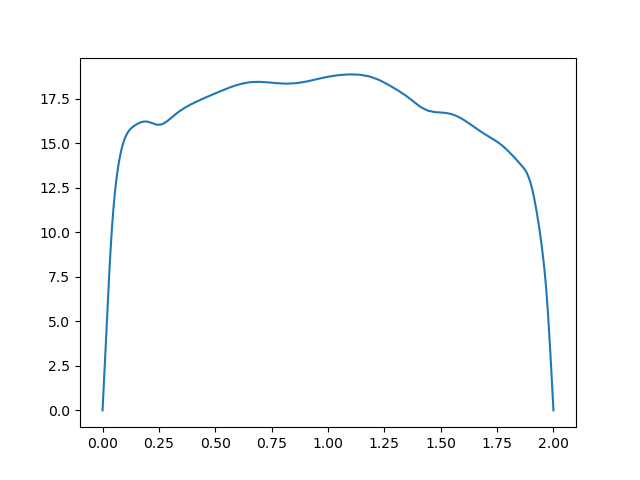

In [15]:
fig, ax = plt.subplots()
ax.plot(sim.y, new_fld[0,10,:,10])

In [16]:
answ = input('Do you want to write the field to disk? [y/n]\n')
if 'y' in answ:
    len_v = new_fld.size
    len_p = n_new["x"] * (n_new["y"]-1) * n_new["z"]
    writebuf = np.zeros((len_v + len_p,),dtype=np.float64)
    writebuf[0:len_v] = new_fld.flatten()
    writebuf.tofile("restart_interpolated", sep='')

Do you want to write the field to disk? [y/n]
 y
